In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import cdist
from scipy.linalg import sqrtm
from scipy.stats import entropy
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_type = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [29]:
inst_dict = {
    '5P' : 'Univ. Hospital Erlangen',
    'AK' : 'Fox Chase',
    'B9' : 'Univ. North California',
    'CJ' : 'MD Anderson Cancer Center'
}
colors = {
    '5P': 'red',
    'AK': 'blue',
    'B9': 'green',
    'CJ': 'purple'
}

TCGA_RCC_PATH = '/data/nas07/Dataset/Image/Camelyon17/feats_tcga_rcc/'

## SAMPLE PER INST_DICT

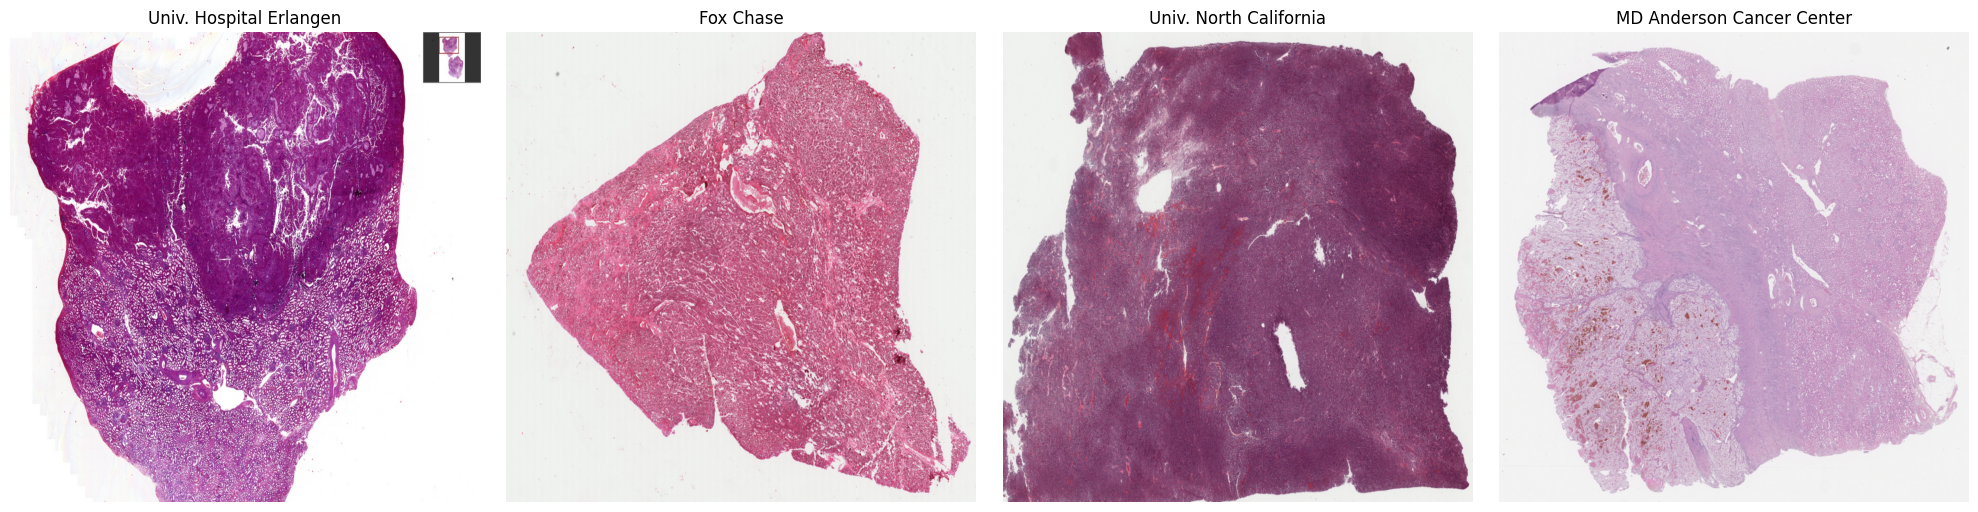

In [32]:
image_dir = "./IMAGE_SAMPLE"
target_size = (1024, 1024)
inst_dict = {
    '5P': 'Univ. Hospital Erlangen',
    'AK': 'Fox Chase',
    'B9': 'Univ. North California',
    'CJ': 'MD Anderson Cancer Center'
}
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
num_images = len(image_files)

fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
if num_images == 1:
    axes = [axes]

for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    file_key = os.path.splitext(img_file)[0]
    title = inst_dict.get(file_key, file_key)
    axes[i].imshow(img)
    axes[i].axis('off')  # Remove axes
    axes[i].set_title(title, fontsize=12)  # Set title from inst_dict

plt.tight_layout()
plt.show()

## T-SNE VISUALIZATION

In [6]:

def load_data(item_path, feats_size, samples_per_bag):
    """Load and process the features from each bag."""
    all_features, all_labels = [], []
    closest_indices = []
    all_centroid_means, all_centroid_stds = [], []
    global_index_offset = 0  # Track the global index across all samples

    for bag_item in item_path:
        stacked_data = torch.load(bag_item, map_location=device)
        bag_feature = tensor_type(stacked_data[:, :feats_size])

        num_samples = min(samples_per_bag, bag_feature.shape[0])
        selected_indices = np.random.choice(bag_feature.shape[0], num_samples, replace=False)
        selected_features = bag_feature[selected_indices, :]
        
        all_features.append(selected_features)
        inst_id = bag_item.split('-')[1]
        all_labels.extend([inst_id] * num_samples)

        # Update the global index offset for the next bag
        global_index_offset += selected_features.shape[0]

    all_features = torch.cat(all_features, dim=0).cpu().numpy()
    
    return all_features, all_labels

In [13]:
def compute_tsne(all_features,all_labels, perplexity=30, learning_rate=200, n_iter=1000):
    """Compute and process the t-sne features from the bag."""
    # scaler = StandardScaler()
    # standardized_features = scaler.fit_transform(original_features)
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=0)
    tsne_results = tsne.fit_transform(all_features)
    return tsne_results

In [20]:
def plot_tsne(tsne_results, all_labels, inst_dict):
    """Plot the t-SNE results and save the plot."""
    plt.figure(figsize=(10, 8))

    institution_colors = ['lightblue', 'lightgreen', 'plum', 'peachpuff']  # Paler color scheme
    markers = ['o', 's', 'D', 'P']  # Use different marker shapes for institutions
    
    unique_institutions = np.unique(all_labels)
    for i, institution in enumerate(unique_institutions):
        institution_mask = np.array(all_labels) == institution
        plt.scatter(
            tsne_results[institution_mask, 0], 
            tsne_results[institution_mask, 1], 
            color=institution_colors[i % len(institution_colors)],  # Cycle through pale colors
            marker=markers[i % len(markers)],  # Cycle through markers
            label=inst_dict[institution],
            alpha=0.7  # Slightly increase transparency for a softer appearance
        )

   
    # plt.title('t-SNE Features by Institution (Closest Features Highlighted)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title="Institution", loc='best')
    plt.show()

In [21]:
sys.stdout.write("Step 1: Loading data...\n")
sys.stdout.flush()
item_path = glob(os.path.join('feats_tcga', '*.pt'))
all_features, all_labels = load_data(item_path, 384, 500)

Step 1: Loading data...


In [22]:
sys.stdout.write("Step 2: Running t-SNE...\n")
sys.stdout.flush()
tsne_results = compute_tsne(all_features, all_labels)


Step 2: Running t-SNE...


/opt/miniconda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Step 2: Visualize t-SNE...


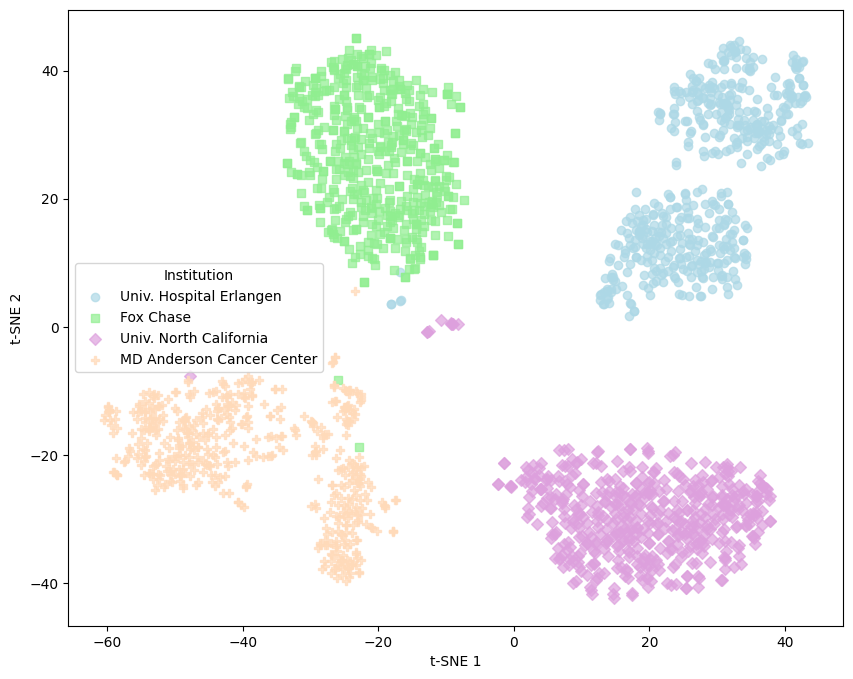

In [24]:
sys.stdout.write("Step 2: Visualize t-SNE...\n")
sys.stdout.flush()
plot_tsne(tsne_results, all_labels, inst_dict)